In [1]:
import pandas as pd
import numpy as np
import os
import re

model_path = "data/university-admissions-2015/models"

def read_model(filename): 
    filepath = model_path + "/" + filename
    tags = ["startEvent", "intermediateCatchEvent", "task", "exclusiveGateway"]
    names = []
    sids = []
    locations = []
    
    with open(filepath, 'r') as file: 
        for line in file:
            line = line.replace('"', '\\"')
            if re.match(r'[ \t]+<\w', line):
                line = re.sub(r'[ \t]+<', '', line)
                words = line.split("\" ")
                tag = words[0].split(" ")[0]
                if tag in tags:
                    if tag == "task": 
                        name = words[-2].replace('name=\\"', '')[:-1]
                        sid = words[1].replace('id=\\"', '')[:-1]
                    else:
                        name = words[-1].replace('name=\\"', '')[:-4]
                        sid = words[0].split(' ')[1].replace('id=\\"', '')[:-1]

                    if name != "":
                        names.append(name)
                        sids.append(sid)
                        locations.append(filename[:-5])
    
    df = pd.DataFrame({"Name": names, "SID": sids, "Location": locations})
    return df

def read_all_models(model_path):
    filenames = [f for f in os.listdir(model_path) if os.path.isfile(os.path.join(model_path, f))]
    dfs = [read_model(filename) for filename in filenames]
    df = pd.concat(dfs)
    return df

models = read_all_models(model_path)
models.at[1,"Name"] = "Send online protocol" # weird characters
models.head()

,Name,SID,Location
0,Apply online,sid-B11703D1-08C3-416B-8947-76CE10A27978,Cologne
1,Send online protocol,sid-2A61C308-48B4-4C26-9CB3-D489A0BBC1E3,Cologne
2,Send documents by post,sid-4C4748D1-DBC6-4155-91C8-F71F3796A768,Cologne
3,Take aptitude test,sid-A3568080-F469-4D86-BB96-7A5C48342857,Cologne
4,Pay for aptitude test,sid-F6E821C8-4300-4AA0-B6D1-6BA5D15FA7DE,Cologne


In [2]:
reference_path = "data/university-admissions-2015/goldstandard"

def read_reference(filename):
    filepath = reference_path + "/" + filename
    sid1s = []
    sid2s = []
    
    with open(filepath, 'r') as file: 
        for line in file:
            line = line.replace('"', '\\"')
            if re.match(r'[ \t]+<\w', line):
                line = re.sub(r'[ \t]+<', '', line)
                words = line.split("\" ")
                tag = words[0].split(" ")[0]
                if "entity" in tag:
                    if tag == "entity1": 
                        sid = re.search(r'sid[-\d\w]+', line)[0]
                        sid1s.append(sid)
                    elif tag == "entity2":
                        sid = re.search(r'sid[-\d\w]+', line)[0]
                        sid2s.append(sid)
    
    # don't append list if sid pairs shouldn't be added reversed
    df = pd.DataFrame({"SID1": sid1s + sid2s, "SID2": sid2s + sid1s})
    return df
    
def read_all_references(reference_path): 
    filenames = [f for f in os.listdir(reference_path) if os.path.isfile(os.path.join(reference_path, f))]
    dfs = [read_reference(filename) for filename in filenames]
    df = pd.concat(dfs)
    return df

references = read_all_references(reference_path)
references.head()

,SID1,SID2
0,sid-50620B60-4F01-4DFD-8EB8-BBCAAECE6026,sid-02B39B7C-7C88-4BCC-AD34-FEED3A2D9E42
1,sid-8712EF38-01F5-4812-ACB7-8F0EF759F38C,sid-445A78A6-1CA7-40BF-B7BF-B8CCCAAEF703
2,sid-B41B5C8F-D1D5-4641-943B-DB396FD69D0B,sid-5108D3F6-5D84-4ECB-B826-1A54D3D17B20
3,sid-DF0BF153-C7B8-47A6-9436-2217B6A02FB9,sid-B296B105-D85C-47FE-A200-50F7C64E65CF
4,sid-4C4748D1-DBC6-4155-91C8-F71F3796A768,sid-234E99B4-0E97-4770-B2CF-AD0DACDF6888


In [3]:
def prepare_expressions(filename):
    if os.path.exists(filename) and os.path.isfile(filename):  
        df = pd.read_csv(filename)
    else: 
        sid_dict = pd.Series(models["Name"].values,index=models["SID"]).to_dict()
        df = references.copy()
        df.replace({"SID1": sid_dict}, inplace=True)
        df.replace({"SID2": sid_dict}, inplace=True)

        df.columns = ["Name1", "Name2"]

        # add expressions reversed
        reversed_cols = pd.DataFrame({"Name1": df["Name2"].tolist(), "Name2": df["Name1"].tolist()})
        df = df.append(reversed_cols)
        df["Equivalent"] = [True] * df.shape[0]

        expressions = models["Name"].tolist()

        for expr1 in expressions:
            for expr2 in expressions:
                if not ((df[['Name1','Name2']].values == [expr1, expr2]).all(axis=1).any()):
                    row = pd.DataFrame({"Name1": [expr1], "Name2": [expr2], "Equivalent": [False]})
                    df = df.append(row)
                
    return df
                
expressions = prepare_expressions("expressions.csv")

In [4]:
expressions.to_csv("expressions.csv", index=False)
expressions.tail()

,Name1,Name2,Equivalent
31044,Matriculate,Send german application,False
31045,Matriculate,Fill in online form of application,False
31046,Matriculate,Receive Commitment,False
31047,Matriculate,Waiting for response,False
31048,Matriculate,Matriculate,False


In [5]:
import nltk
nltk.download()
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 
def preprocess_text(text):
    text = ' '.join([lemmatizer.lemmatize(word.lower()) for word in text.split() if word not in stop_words])
    return text

expressions['Name1'] = expressions['Name1'].apply(lambda x: preprocess_text(x))
expressions['Name2'] = expressions['Name2'].apply(lambda x: preprocess_text(x))
expressions.head()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


,Name1,Name2,Equivalent
0,send letter rejection,send letter rejection,True
1,rejected,rejected,True
2,check document,check document,True
3,wait result,wait result,True
4,send document post,send online protocol,True


In [6]:
expressions.loc[expressions["Name1"] == expressions["Name2"], "Equivalent"] = True
expressions.tail()

,Name1,Name2,Equivalent
31044,matriculate,send german application,False
31045,matriculate,fill online form application,False
31046,matriculate,receive commitment,False
31047,matriculate,waiting response,False
31048,matriculate,matriculate,True


In [7]:
from gensim.models import Word2Vec

all_words = [word for sent in expressions['Name1'].tolist() for word in sent.split()] 
all_sents = [sent.split() for sent in expressions['Name1'].tolist()]
word2vec = Word2Vec(all_sents, min_count=2)

In [8]:
import scipy
def cosine_similarity(text1, text2, model):
    if model == "word2vec":
        v1 = np.mean([word2vec[word] for word in text1.split()],axis=0)
        v2 = np.mean([word2vec[word] for word in text2.split()],axis=0)
        cosine = scipy.spatial.distance.cosine(v1,v2)
    else:
        v1 = doc2vec.infer_vector(text1.split())
        v2 = doc2vec.infer_vector(text2.split())
        cosine = scipy.spatial.distance.cosine(v1, v2)
    return cosine

expressions['CosDistW'] = expressions.apply(lambda x: cosine_similarity(x["Name1"], x["Name2"], "word2vec"), axis=1)
expressions.tail()

D:\Programme\Sprachen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
D:\Programme\Sprachen\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


,Name1,Name2,Equivalent,CosDistW
31044,matriculate,send german application,False,1.003904
31045,matriculate,fill online form application,False,1.023672
31046,matriculate,receive commitment,False,0.924264
31047,matriculate,waiting response,False,1.103847
31048,matriculate,matriculate,True,0.000000


In [9]:
def word_movers_distance(sent1, sent2, model):
    if model == "word2vec":
        distance = word2vec.wmdistance(sent1.split(), sent2.split())
    else:
        v1 = doc2vec.infer_vector(sent1.split())
        v2 = doc2vec.infer_vector(sent2.split())
        distance = doc2vec.wmdistance(sent1, sent2)
    return distance

expressions['WordDistW'] = expressions.apply(lambda x: word_movers_distance(x["Name1"], x["Name2"], "word2vec"), axis=1)
expressions.tail()

D:\Programme\Sprachen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


,Name1,Name2,Equivalent,CosDistW,WordDistW
31044,matriculate,send german application,False,1.003904,3.216843
31045,matriculate,fill online form application,False,1.023672,3.940703
31046,matriculate,receive commitment,False,0.924264,2.513571
31047,matriculate,waiting response,False,1.103847,3.124907
31048,matriculate,matriculate,True,0.000000,0.000000


In [10]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

list_of_sentences = [" ".join(sublist) for sublist in all_sents]
#sentences = [TaggedDocument(sent, [i]) for i, sent in enumerate(list_of_sentences)]
sentences = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(list_of_sentences)]

doc2vec = Doc2Vec(size=15, alpha=0.025, min_alpha=0.00025, min_count=1, dm =1)
doc2vec.build_vocab(sentences)
    
def train_doc2vec(epochs):
    for epoch in range(epochs):
        doc2vec.train(sentences, total_examples=doc2vec.corpus_count, epochs=doc2vec.iter)
        # decrease the learning rate
        doc2vec.alpha -= 0.0002
        # fix the learning rate, no decay
        doc2vec.min_alpha = doc2vec.alpha
        
train_doc2vec(10)

D:\Programme\Sprachen\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
D:\Programme\Sprachen\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  del sys.path[0]


In [11]:
expressions['CosDistD'] = expressions.apply(lambda x: cosine_similarity(x["Name1"], x["Name2"], "doc2vec"), axis=1)
expressions['WordDistD'] = expressions.apply(lambda x: word_movers_distance(x["Name1"], x["Name2"], "doc2vec"), axis=1)
expressions.head()

D:\Programme\Sprachen\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  import sys


,Name1,Name2,Equivalent,CosDistW,WordDistW,CosDistD,WordDistD
0,send letter rejection,send letter rejection,True,0.000000,0.000000,0.798607,0.0
1,rejected,rejected,True,0.000000,0.000000,0.060280,0.0
2,check document,check document,True,0.000000,0.000000,0.195001,0.0
3,wait result,wait result,True,0.000000,0.000000,0.353769,0.0
4,send document post,send online protocol,True,0.113114,1.659611,0.631033,0.0


In [12]:
expressions["Equivalent"] = expressions["Equivalent"].astype(int)
expressions = expressions.replace([np.inf, -np.inf], np.nan)
expressions = expressions.dropna()
expressions.head()

,Name1,Name2,Equivalent,CosDistW,WordDistW,CosDistD,WordDistD
0,send letter rejection,send letter rejection,1,0.000000,0.000000,0.798607,0.0
1,rejected,rejected,1,0.000000,0.000000,0.060280,0.0
2,check document,check document,1,0.000000,0.000000,0.195001,0.0
3,wait result,wait result,1,0.000000,0.000000,0.353769,0.0
4,send document post,send online protocol,1,0.113114,1.659611,0.631033,0.0


In [13]:
expressions["Equivalent"].value_counts()

0    28274
1     1015
Name: Equivalent, dtype: int64

In [14]:
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

df = expressions.copy()
df_majority = df[df["Equivalent"] == 0]
df_minority = df[df["Equivalent"] == 1]

n_majority = expressions["Equivalent"].value_counts().max()
df_minority_upsampled = resample(df_minority, replace=True, n_samples=n_majority, random_state=42)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled["Equivalent"].value_counts()

1    28274
0    28274
Name: Equivalent, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split

important_cols = ["CosDistW", "WordDistW", "CosDistD", "WordDistD"]

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(df_upsampled[important_cols], df_upsampled["Equivalent"], test_size=0.2, random_state=42, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(df[important_cols], df["Equivalent"], test_size=0.2, random_state=522, shuffle=True)

In [22]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion = "gini", splitter = 'random', max_leaf_nodes = 10, min_samples_leaf = 5, max_depth= 5)
#decision_tree = DecisionTreeClassifier()
scores = cross_val_score(decision_tree, X_train_u, y_train_u, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(decision_tree, X_train_u, y_train_u, cv=5, scoring='f1_macro')

Accuracy: 0.86 (+/- 0.02)


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

decision_tree.fit(X_train_u, y_train_u)
y_pred = decision_tree.predict(X_test)
print("accuracy ", accuracy_score(y_test, y_pred))
print("precision ", precision_score(y_test, y_pred))
print("recall ", recall_score(y_test, y_pred))

accuracy  0.9419597132127006
precision  0.34490238611713664
recall  0.8071065989847716


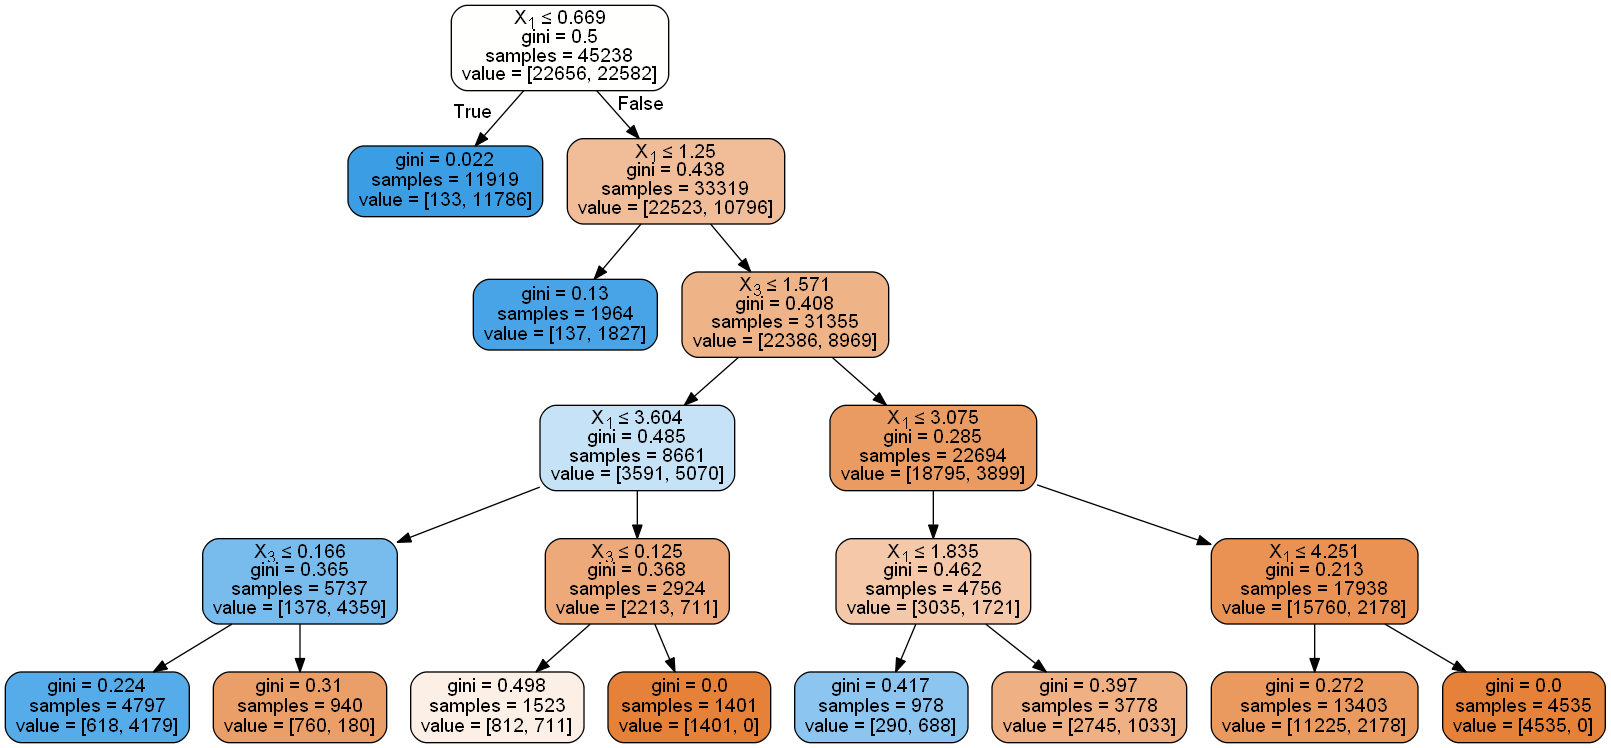

In [24]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(decision_tree, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [25]:
for name, score in zip(important_cols, decision_tree.feature_importances_):
    print(name, score)

CosDistW 0.0
WordDistW 0.778835819930985
CosDistD 0.0
WordDistD 0.22116418006901495


In [37]:
def pipeline(model_path, reference_path, combined_filename):
    models = read_all_models(model_path)
    references = read_all_references(reference_path)
    expressions = prepare_expressions(combined_filename) # csv!!!
    expressions.to_csv(combined_filename, index=False)
    expressions['Name1'] = expressions['Name1'].apply(lambda x: preprocess_text(x))
    expressions['Name2'] = expressions['Name2'].apply(lambda x: preprocess_text(x))
    expressions.loc[expressions["Name1"] == expressions["Name2"], "Equivalent"] = True
    all_words = [word for sent in expressions['Name1'].tolist() for word in sent.split()] 
    all_sents = [sent.split() for sent in expressions['Name1'].tolist()]
    word2vec = Word2Vec(all_sents, min_count=2)
    expressions['CosDistW'] = expressions.apply(lambda x: cosine_similarity(x["Name1"], x["Name2"], "word2vec"), axis=1)
    expressions['WordDistW'] = expressions.apply(lambda x: word_movers_distance(x["Name1"], x["Name2"], "word2vec"), axis=1)
    
    list_of_sentences = [" ".join(sublist) for sublist in all_sents]
    sentences = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(list_of_sentences)]

    doc2vec = Doc2Vec(size=15, alpha=0.025, min_alpha=0.00025, min_count=1, dm =1)
    doc2vec.build_vocab(sentences)
    train_doc2vec(10)
    
    expressions['CosDistD'] = expressions.apply(lambda x: cosine_similarity(x["Name1"], x["Name2"], "doc2vec"), axis=1)
    expressions['WordDistD'] = expressions.apply(lambda x: word_movers_distance(x["Name1"], x["Name2"], "doc2vec"), axis=1)
    
    expressions["Equivalent"] = expressions["Equivalent"].astype(int)
    expressions = expressions.replace([np.inf, -np.inf], np.nan)
    expressions = expressions.dropna()
    
    df = expressions.copy()    
    important_cols = ["CosDistW", "WordDistW", "CosDistD", "WordDistD"]
    X_train, X_test, y_train, y_test = train_test_split(df[important_cols], df["Equivalent"], test_size=0.2, random_state=42, shuffle=True)
    return X_train, y_train, expressions

ua17_models = "data/university-admissions-2017/dataset-bpmn/bpmn-models"
ua17_references = "data/university-admissions-2017/dataset-bpmn/reference"
ua17_combined = "ua17_data.csv"
X_train2, y_train2, names = pipeline(ua17_models, ua17_references, ua17_combined)

y_pred = decision_tree.predict(X_train2)
print("accuracy ", accuracy_score(y_train2, y_pred))
print("precision ", precision_score(y_train2, y_pred))
print("recall ", recall_score(y_train2, y_pred))

D:\Programme\Sprachen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
D:\Programme\Sprachen\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
D:\Programme\Sprachen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Programme\Sprachen\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` i

accuracy  0.9396099184840596
precision  0.35108583247156155
recall  0.8092967818831943


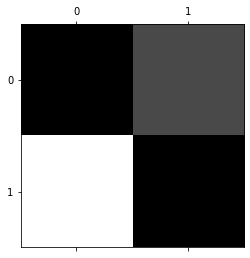

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_mx = confusion_matrix(y_train2, y_pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [39]:
cl_a, cl_b = 0, 1
X_aa = X_train2[(y_train2 == cl_a) & (y_pred == cl_a)]
X_ab = X_train2.index[(y_train2 == cl_a) & (y_pred == cl_b)].tolist()
X_ba = X_train2[(y_train2 == cl_b) & (y_pred == cl_a)]
X_bb = X_train2[(y_train2 == cl_b) & (y_pred == cl_b)]

names.iloc[X_ab,:2]

IndexError: positional indexers are out-of-bounds

In [ ]:
# nur auf bestimmten features?
# fehler inspizieren
# nicht aufsamplen?